<img src="https://www.th-ab.de/typo3conf/ext/th_ab/Resources/Public/assets/logo-th-ab.svg" alt="TH-AB Logo" width="200"/>

Prof. Dr. Möckel, Prof. Dr. Radke, Katharina Kuhnert

Maschinelles Lernen Schwerpunkt Data Science<br>
SoSe 2024

# Übung 8.1: Vergleich von Modellen und Methoden

# Wichtig:

Bitte in Anaconda3 nachinstallieren:

* graphviz 
* python-graphviz

### Bibliotheken importieren und PyTorch Umgebung prüfen

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# PyTorch
try:
    import torch
    import torchvision
    import torchmetrics
except:
    !pip install torch
    !pip install torchvision
    !pip install torchmetrics
    import torch
    import torchvision
    import torchmetrics

from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import rgb_to_grayscale
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models

# MedMNIST
try:
    import medmnist
except:
    !pip install medmnist

import medmnist
from medmnist import INFO, Evaluator

from sklearn.metrics import classification_report, auc, roc_curve

try:
    from torchviz import make_dot
except:
    # Bitte in Conda nachinstallieren: conda install graphviz python-graphviz
    !pip install torchviz

from torchviz import make_dot
from IPython.display import Image

In [2]:
# PyTorch Version überprüfen
if (torch.__version__ < "2.0.0"):
    raise Exception("Wrong PyTorch version")
else:
    print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.3.0+cpu


Nutze GPU für beschleunigtes Maschinelles Lernen

In [3]:
# # Überprüfe Umgebung auf MPS
# print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
# print(f"Is MPS available? {torch.backends.mps.is_available()}")

# # Wähle Device (Fallback ist "cpu")
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
device = torch.device(device)
print(f"Using device: {device}")

Using device: cpu


### Datasets laden

In [4]:
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# Zeige Infos über Dataset
info

{'python_class': 'BloodMNIST',
 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1',
 'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'url_64': 'https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1',
 'MD5_64': '2b94928a2ae4916078ca51e05b6b800b',
 'url_128': 'https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1',
 'MD5_128': 'adace1e0ed228fccda1f39692059dd4c',
 'url_224': 'https://zenodo.org/records/10519652/files/bloodmnist

In [5]:
# Nutze eine Batch-größe von 128
BATCH_SIZE = 128

# Erzeuge Datatransformer (mehrere Transformationen hintereinander)
data_transform = transforms.Compose([
    # Daten zu Tensoren
    transforms.ToTensor(),
    # Normalisiere Daten
    transforms.Normalize(mean=[.5], std=[.5]),
    # RGB zu Graustufen
    transforms.Grayscale(num_output_channels=1)
])

# Dataset für Training
train_dataset = DataClass(split='train', transform=data_transform, download=download)

# Dataset für Validierung
val_dataset = DataClass(split='val', transform=data_transform, download=download)

# Dataset für Test
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Erzeuge DataLoader mit Datasets
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 35461855/35461855 [00:06<00:00, 5464295.47it/s]


Using downloaded and verified file: /home/vscode/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/bloodmnist.npz


#### Dataset Splitting in 50 und 75 Prozent für Vergleiche

In [6]:
# Splitte Train Datasets (prozentual)
train_dataset_50, dont_care = torch.utils.data.random_split(train_dataset, (0.5, 0.5))
train_dataset_75, dont_care = torch.utils.data.random_split(train_dataset, (0.75, 0.25))

# Erzeuge DataLoader mit Datasets
train_loader_50 = data.DataLoader(dataset=train_dataset_50, batch_size=BATCH_SIZE, shuffle=True)
train_loader_75 = data.DataLoader(dataset=train_dataset_75, batch_size=BATCH_SIZE, shuffle=True)

### Analysiere Dataset

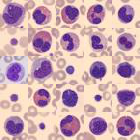

In [7]:
train_dataset.montage(length=5)

/tmp/ipykernel_754/3169023864.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(train_dataset.info["label"][str(int(label))][:8])


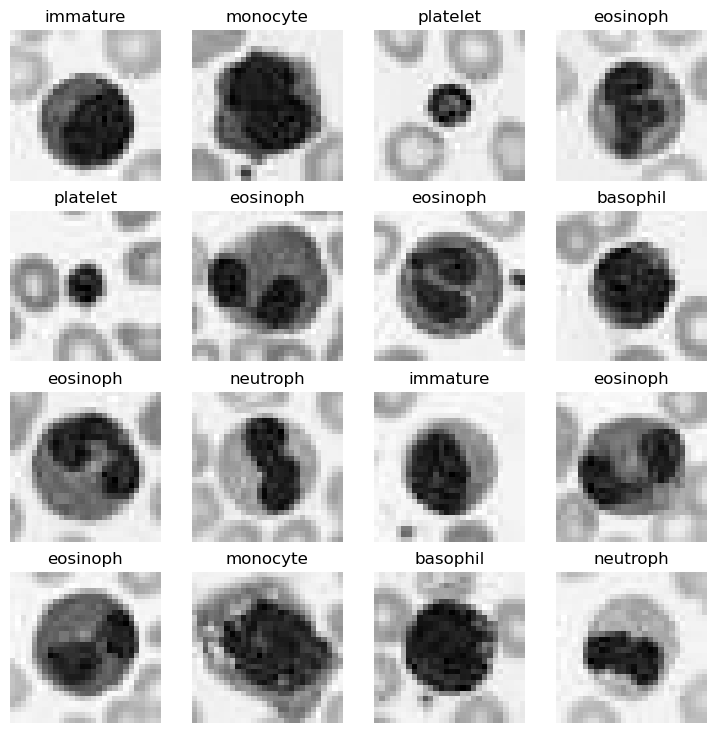

In [8]:
# Setze den Seed für die Generierung von Zufallszahlen
torch.manual_seed(42)

# Plotte eine Matrix aus zufälligen Features und Labels des Datasets
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_loader.dataset), size=[1]).item()
    img, label = train_loader.dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    # Label kürzen falls zu lang
    plt.title(train_dataset.info["label"][str(int(label))][:8])
    plt.axis(False)

In [9]:
# Für alle Samples gilt: Breite = Höhe
SAMPLE_SIZE = train_loader.dataset[0][0].shape[1] **2

# Anzahl der Output Klassen
OUTPUT_CLASSES = len(train_loader.dataset.info['label'])

print("[color_channels, height, width] ->", train_loader.dataset[0][0].shape)
print("Sample Anzahl Pixel:", SAMPLE_SIZE)
print("Ausgabeklassen:", OUTPUT_CLASSES)

[color_channels, height, width] -> torch.Size([1, 28, 28])
Sample Anzahl Pixel: 784
Ausgabeklassen: 8


### Definiere: Multi Layer Perzeptron

In [10]:
class MLP_model(nn.Module):
    def __init__(self, input_channels: int, hidden_units: int, output_channels: int):
        # Konstruktor der Basisklasse aufrufen
        super().__init__()

        # Neuronale Netz konstruieren
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_channels, out_features=hidden_units[0]),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units[0], out_features=hidden_units[1]),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units[1], out_features=output_channels),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layer_stack(x.to(device))

    @property
    def model(self):
        return self.layer_stack

model_mlp = MLP_model(
    # Input ist Feature (Bild) mit 28 x 28 Pixeln in Größe
    input_channels=SAMPLE_SIZE,
    # Erzeuge Neuronen im Hidden Layer welche den Output in jedem Layer reduzieren
    hidden_units=[32, 16],
    # Output Layer ist die Anzahl der Klassen für eine Klassifikation
    output_channels=OUTPUT_CLASSES
).to(device)

model_mlp

MLP_model(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=8, bias=True)
    (6): Softmax(dim=1)
  )
)

### Zeige MLP als Graph

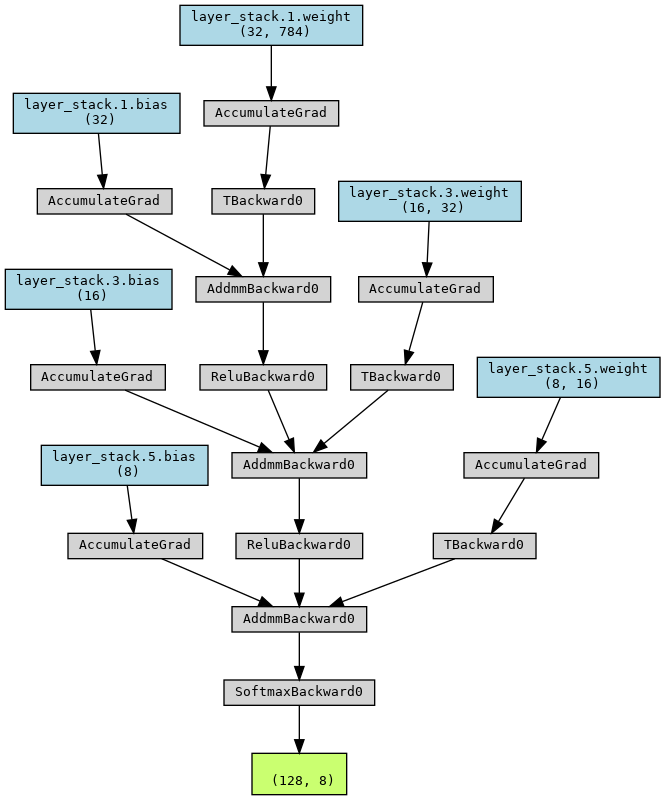

In [11]:
# Lade beliebiges Dataset
X, y = next(iter(train_loader))

# Führe Modell aus
yhat = model_mlp(X)

# Erzeuge Graph
make_dot(yhat, params=dict(list(model_mlp.named_parameters()))).render("mlp_torchviz", format="png")

# Zeige PNG Graph
Image("mlp_torchviz.png")

### Definiere: Komplexes CNN

In [12]:
# Definiere CNN Modell
class CNN_model(nn.Module):
    def __init__(self, input_channels: int, hidden_units: int, output_channels: int):
        # Konstruktor der Basisklasse aufrufen
        super().__init__()

        # Neuronale Netz konstruieren

        # Konstruiere 1. Block (Input Conv2d -> ReLU -> Hidden Conv2d -> ReLU -> MaxPool2d)
        self.block_1 = nn.Sequential(
            # Schritt 1: Verknüpfung von Inputs und der Hidden Layer
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=hidden_units[0],
                # Größe des convolving Kernels
                kernel_size=3,
                # Schrittweite
                stride=1,
                # Padding für Input festlegen
                padding=1,
                # bias deaktivieren
                bias=False
            ),
            # Schritt 2: Verknüpfung Hidden Layer
            nn.Conv2d(
                in_channels=hidden_units[0],
                out_channels=hidden_units[0],
                kernel_size=3,
                stride=1,
                padding=1
            ),
            # Schritt 3: ReLU Aktivierungsfunktion
            nn.ReLU(),
            # Schritt 4: Reduktion
            # Max-Pooling reduziert die Dimensionalität von Bildern, 
            # indem die Anzahl der Pixel in der Ausgabe der vorherigen 
            # Faltungsschicht reduziert wird.
            # Reduktion von: 28 -> 14
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Konstruiere 2. Block (Hidden Conv2d -> ReLU -> Hidden Conv2d -> ReLU -> MaxPool2d)
        self.block_2 = nn.Sequential(
            # Schritt 1: Verknüpfung Hidden Layer
            nn.Conv2d(hidden_units[0], hidden_units[1], 3, padding=1),
            # Schritt 2: ReLU Aktivierungsfunktion
            nn.ReLU(),
            # Schritt 3: Verknüpfung Hidden Layer
            nn.Conv2d(hidden_units[1], hidden_units[1], 3, padding=1),
            # Schritt 4: ReLU Aktivierungsfunktion
            nn.ReLU(),
            # Schritt 5: Reduktion
            # Reduktion von: 14 -> 7
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Konstruiere Klassifizierer NN Output
        self.classifier = nn.Sequential(
            # Schritt 1: Umwandeln in Vektor
            nn.Flatten(),
            # Schritt 2: Verknüpfen von Hidden Layers mit Output
            nn.Linear(in_features=hidden_units[1]*7*7, out_features=output_channels)
        )
    
    def forward(self, x):
        # Durchlaufe Block 1
        x = self.block_1(x)
        # Durchlaufe Block 2
        x = self.block_2(x)
        # Durchlaufe Klassifizierer
        x = self.classifier(x)

        return x

model_cnn = CNN_model(
    # Input ist Feature (Bild) mit 28 x 28 Pixeln in Größe mit 1 Farbkanal
    # Achtung: input_shape = Anzahl der Farbkanäle im Bild
    input_channels = 1,
    # Erzeuge Neuronen im Hidden Layer welche den Output in jedem Layer reduzieren
    hidden_units = [32, 16],
    # Output Layer ist die Anzahl der Klassen für eine Klassifikation
    output_channels = OUTPUT_CLASSES
).to(device)

model_cnn

CNN_model(
  (block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=8, bias=True)
  )
)

### Zeige komplexes CNN als Graph

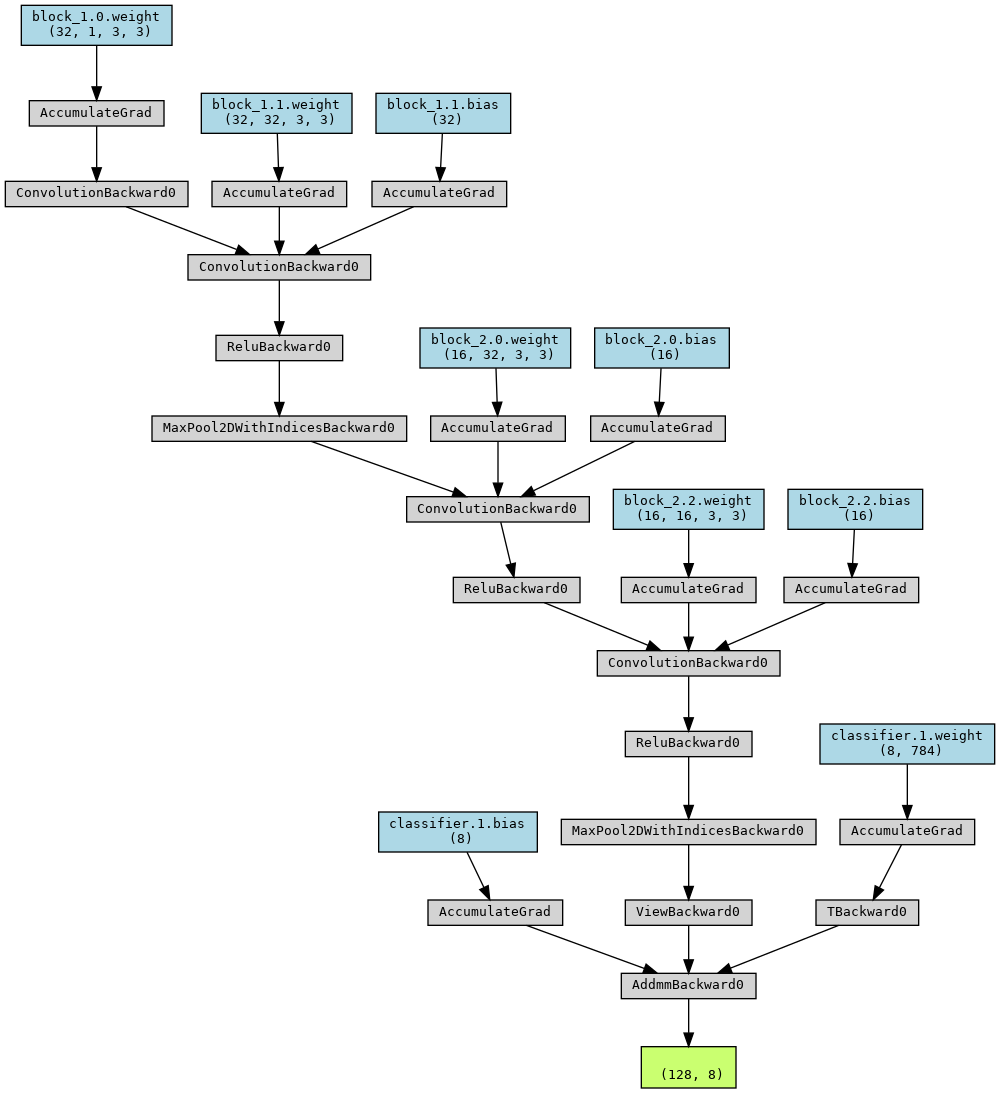

In [13]:
# Lade beliebiges Dataset
X, y = next(iter(train_loader))

# Führe Modell aus
yhat = model_cnn(X)

# Erzeuge Graph
make_dot(yhat, params=dict(list(model_cnn.named_parameters()))).render("cnn_torchviz", format="png")

# Zeige PNG Graph
Image("cnn_torchviz.png")

### Definiere: Vereinfachtes CNN

In [14]:
# Definiere CNN Modell
class CNN_simple_model(nn.Module):
    def __init__(self, input_channels: int, hidden_units: int, output_channels: int):
        # Konstruktor der Basisklasse aufrufen
        super().__init__()

        # Neuronale Netz konstruieren

        # Konstruiere 1. Block (Input Conv2d -> ReLU -> Hidden Conv2d -> ReLU -> MaxPool2d)
        self.block_1 = nn.Sequential(
            # Schritt 1: Verknüpfung von Inputs und der Hidden Layer
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=hidden_units,
                # Größe des convolving Kernels
                kernel_size=3,
                # Schrittweite
                stride=1,
                # Padding für Input festlegen
                padding=1
            ),
            # Schritt 2: Verknüpfung Hidden Layer
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            # Schritt 3: Tanh Aktivierungsfunktion
            nn.Tanh(),
            # Schritt 4: Reduktion
            # Max-Pooling reduziert die Dimensionalität von Bildern, 
            # indem die Anzahl der Pixel in der Ausgabe der vorherigen 
            # Faltungsschicht reduziert wird.
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Konstruiere 2. Block (Hidden Conv2d -> ReLU -> Hidden Conv2d -> ReLU -> MaxPool2d)
        self.block_2 = nn.Sequential(
            # Schritt 1: Verknüpfung Hidden Layer
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            # Schritt 2: Tanh Aktivierungsfunktion
            nn.Tanh(),
            # Schritt 3: Verknüpfung Hidden Layer
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            # Schritt 4: Tanh Aktivierungsfunktion
            nn.Tanh(),
            # Schritt 5: Reduktion
            nn.MaxPool2d(2)
        )

        # Konstruiere Klassifizierer NN Output
        self.classifier = nn.Sequential(
            # Schritt 1: Umwandeln in Vektor
            nn.Flatten(),
            # Schritt 2: Verknüpfen von Hidden Layers mit Output
            nn.Linear(in_features=hidden_units*7*7, out_features=output_channels)
        )
    
    def forward(self, x):
        # Durchlaufe Block 1
        x = self.block_1(x)
        # Durchlaufe Block 2
        x = self.block_2(x)
        # Durchlaufe Klassifizierer
        x = self.classifier(x)

        return x

model_cnn_simple = CNN_simple_model(
    # Input ist Feature (Bild) mit 28 x 28 Pixeln in Größe mit 1 Farbkanal
    # Achtung: input_shape = Anzahl der Farbkanäle im Bild
    input_channels = 1,
    # Erzeuge Neuronen im Hidden Layer welche den Output in jedem Layer reduzieren
    hidden_units = 8,
    # Output Layer ist die Anzahl der Klassen für eine Klassifikation
    output_channels = OUTPUT_CLASSES
).to(device)

model_cnn_simple

CNN_simple_model(
  (block_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=392, out_features=8, bias=True)
  )
)

### Zeige vereinfachtes CNN als Graph

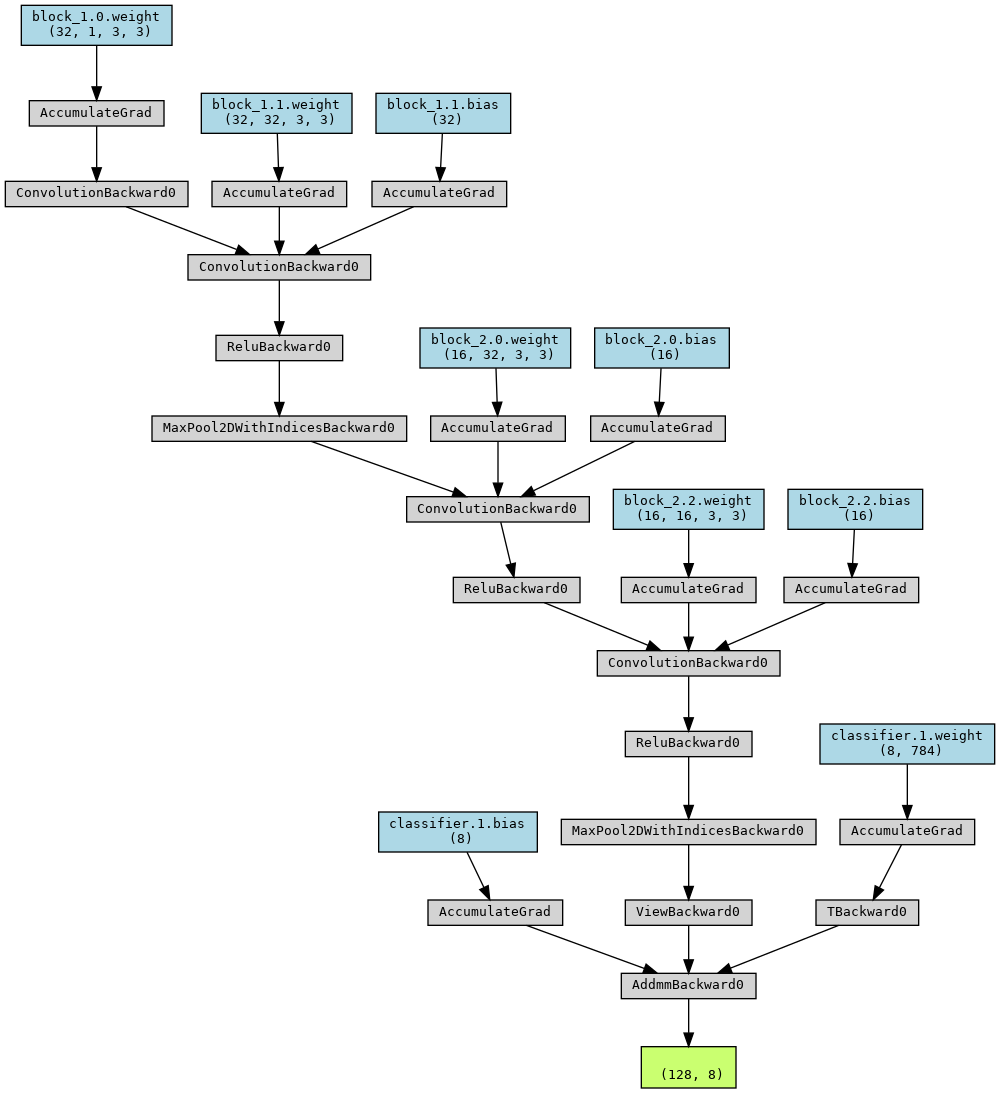

In [15]:
# Lade beliebiges Dataset
X, y = next(iter(train_loader))

# Führe Modell aus
yhat = model_cnn_simple(X)

# Erzeuge Graph
make_dot(yhat, params=dict(list(model_cnn_simple.named_parameters()))).render("cnn_simple_torchviz", format="png")

# Zeige PNG Graph
Image("cnn_torchviz.png")

### Evaluationsfunktion

#### Naiver Ansatz:

Precision wird nur mit Platzhalterwert $0$ zurückgegeben!

In [16]:
def evaluate_accuracy_naive(logits, y_true):
    # Ermittle Indizes mit dem jeweils höchsten Wert
    _, y_pred = torch.max(logits, dim=1)

    # Berechne Anteile korrekter Prediktionen
    correct_pred = (y_pred == y_true).float()
    acc = correct_pred.sum() / len(correct_pred)
    # acc *= 100

    # Keine Berechnung von Precision!
    prec = 0

    return acc, prec

#### Multi-Class Evaluation:

In [17]:
def evaluate_accuracy_more_precise(y_pred: torch.Tensor, y_true):
    acc = 0
    prec = 0

    # Hole den Indexwert (=Label) des Arrayelements
    # mit dem höchsten (Wahrscheinlichkeits-) Wert
    # Der Ursprungstensor enthält für jede Prediction 
    # Wahrscheinlichkeitswerte für alle Labels.
    # Für den Klassifikationsreport verwenden wir aus einer
    # Prediction nur das Label mit dem höchsten Wahrscheinlichkeitswert.
    reduce_pred = lambda f : [ i.argmax() for i in f ] 

    # Reduziere Prediktionen
    y_pred_red = reduce_pred(y_pred.detach().numpy())

    # Erzeuge Klassifkationsreport
    result = classification_report(y_true.detach().numpy().tolist(), y_pred_red, output_dict=True, zero_division=0)

    acc = result['accuracy']
    prec = result['weighted avg']['precision']

    return acc, prec

### Zu verwendende Evaluationsfunktion festlegen

In [18]:
# Modus für Evaluation festlegen
# USE_NAIVE_EVALUATION = False

# match USE_NAIVE_EVALUATION:
#    case True:
#        evaluate_accuracy = evaluate_accuracy_naive
#    case False:
#        evaluate_accuracy = evaluate_accuracy_more_precise

In [19]:
evaluate_accuracy = evaluate_accuracy_more_precise

### Fehlerfunktion und Kostenfunktion festlegen

In [20]:
# Lege Lernrate fest
LEARN_RATE = 0.001

# Definiere Fehlerfunktion
loss_fn = nn.CrossEntropyLoss()

# Definiere Optimizer für Modelle
optimizer_mlp = torch.optim.Adam(params=model_mlp.parameters(), lr=LEARN_RATE)
# optimizer_mlp = torch.optim.SGD(params=model_mlp.parameters(), lr=LEARN_RATE)

optimizer_cnn = torch.optim.Adam(params=model_cnn.parameters(), lr=LEARN_RATE)
# optimizer_cnn = torch.optim.SGD(params=model_cnn.parameters(), lr=LEARN_RATE)

optimizer_cnnc = torch.optim.Adam(params=model_cnn_simple.parameters(), lr=LEARN_RATE)
# optimizer_cnn = torch.optim.SGD(params=model_cnn_simple.parameters(), lr=LEARN_RATE)

### Trainingsfunktion

Quelle für Funktion: https://tomytjandra.github.io/blogs/python/classification/computer-vision/pytorch/2021/08/27/mnist-digit-pytorch.html

In [21]:
def train(
    model: nn.Module, 
    train_loader: data.DataLoader, 
    val_loader: data.DataLoader, 
    loss_fn,
    optimizer,
    n_epochs: int,
    model_file_name='model.pt'
):
    # Container für Trainingsergebnisse
    history = {
        'n_epochs': n_epochs,
        'train_duration': [],
        'loss': {
            'train': [],
            'val': []
        },
        'acc': {
            'train': [],
            'val': []
        },
        'precision': {
            'train': [],
            'val': []
        }
    }

    ################
    # TRAINING
    ################

    # Initializere Ergebnis für minimalen Valididerungsfehler
    val_loss_min = np.Inf

    # Schleife für Epochen
    for epoch in range(n_epochs):

        # Initialisiere Trainingsergebnisse
        train_acc = 0
        train_loss = 0
        train_prec = 0
        train_duration = time.time()

        # Initiiere Modell in den Trainingsmodus (kein Training! Nur Modus setzen.)
        model.train()

        # Schleife für Batches
        for X, y in train_loader:

            # if (device != None):
            # Weise Features und Labels Device zu
            X, y = X.to(device), y.to(device)

            # Initiiere Optimizer Gradients auf 0
            optimizer.zero_grad()

            # Anwendung des Modells auf Feature-Batch
            y_pred = model(X)

            # Fix für long - int Tensor Typ Problem unter Windows
            y_conv = y[:, 0].clone().detach()
            y_target = y_conv.type(torch.long) 

            # Berechne Fehler
            # -> y[:, 0] Transformiere Target Tensor in Vektor mit 1D!
            loss = loss_fn(y_pred, y_target)

            # Initiiere Rückwärtspropagation des Fehlers
            loss.backward()
            
            # Aktualisiere Gewichte
            optimizer.step()
            
            # Berechne Verlust und Genauigkeit
            train_loss += loss.item() * X.size(0)
            # Berechne Metriken
            acc, prec = evaluate_accuracy(y_pred.cpu(), y[:, 0].cpu())
            # Speichere Genauigkeit
            train_acc += acc * X.size(0)
            # Speichere Precision
            train_prec += prec * X.size(0)

        # Berechne und speichere Trainingsdauer
        train_duration = time.time() - train_duration
        history['train_duration'].append(train_duration)


        ################
        # Validierung
        ################

        # Schalte Gradientenberechnung für Validierung aus
        with torch.no_grad():

            # Initialisiere Validierungsergebnisse
            val_acc = 0
            val_loss = 0
            val_prec = 0

            # Versetze Modell in Evaluationsmodus (keine Evaluation hier!)
            model.eval()

            # Schleife für Batches
            for X, y in val_loader:
                
                # if (device != None):
                # Weise Features und Labels Device zu
                X, y = X.to(device), y.to(device)

                # Ausführung des Modells
                y_pred = model(X)

                # Fix für long - int Tensor Typ Problem unter Windows
                y_conv = y[:, 0].clone().detach()
                y_target = y_conv.type(torch.long)

                # Berechne Validierungsfehler
                loss = loss_fn(y_pred, y_target)
                # Speichere Validierungsfehler
                val_loss += loss.item() * X.size(0)
                # Berechne Metriken
                acc, prec = evaluate_accuracy(y_pred.cpu(), y[:, 0].cpu())
                # Speichere Genauigkeit
                val_acc += acc * X.size(0)
                # Speichere Precision
                val_prec += prec * X.size(0)

        ################
        # Berechne Trainingsergebnisse
        ################

        # Berechne Durchschnittsfehler
        train_loss /= len(train_loader.sampler)
        val_loss /= len(val_loader.sampler)
        history['loss']['train'].append(train_loss)
        history['loss']['val'].append(val_loss)

        # Berechne Durchschnittsgenauigkeit / Präzision
        train_acc /= len(train_loader.sampler)
        train_prec /= len(train_loader.sampler)
        val_acc /= len(val_loader.sampler)
        val_prec /= len(val_loader.sampler)
        history['acc']['train'].append(train_acc)
        history['precision']['train'].append(train_prec)
        history['acc']['val'].append(val_acc)
        history['precision']['val'].append(val_prec)

        # Ausgabe
        print(f'Epoch {epoch+1:03} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}')
        print(f'Train Prec: {train_prec:.2f} | Val Prec: {val_prec:.2f}')

        # Speichere Modell bei Verringerung des Fehlers bei Validierung
        if val_loss <= val_loss_min:
            print(
                f'Validation loss decreased ({val_loss_min:.5f} --> {val_loss:.5f})  Saving model to {model_file_name}...')
            #torch.save(model.state_dict(), model_file_name)
            val_loss_min = val_loss

        print()

    return history

#### Trainingsparameter

In [22]:
# Epochen für Training einstellen
EPOCHS = 4
# EPOCHS = 16
# EPOCHS = 32
# EPOCHS = 100

# Dataset (-Loader) für Training wählen
tl = train_loader
# tl = train_loader_50
# tl = train_loader_75

### Trainiere: MLP

In [23]:
history_mlp = train(
    model_mlp, tl, val_loader, loss_fn, optimizer_mlp, n_epochs=EPOCHS,
    model_file_name='cache/model_mlp.pt'
)

print("Trainingsdauer: {:.2f} Sekunden".format(np.sum(history_mlp['train_duration'])))

Epoch 001 | Train Loss: 1.88858 | Val Loss: 1.73587 | Train Acc: 0.43 | Val Acc: 0.60
Train Prec: 0.30 | Val Prec: 0.50
Validation loss decreased (inf --> 1.73587)  Saving model to cache/model_mlp.pt...

Epoch 002 | Train Loss: 1.69702 | Val Loss: 1.66632 | Train Acc: 0.61 | Val Acc: 0.63
Train Prec: 0.51 | Val Prec: 0.52
Validation loss decreased (1.73587 --> 1.66632)  Saving model to cache/model_mlp.pt...

Epoch 003 | Train Loss: 1.66486 | Val Loss: 1.64983 | Train Acc: 0.62 | Val Acc: 0.64
Train Prec: 0.52 | Val Prec: 0.53
Validation loss decreased (1.66632 --> 1.64983)  Saving model to cache/model_mlp.pt...

Epoch 004 | Train Loss: 1.65458 | Val Loss: 1.64100 | Train Acc: 0.63 | Val Acc: 0.64
Train Prec: 0.53 | Val Prec: 0.54
Validation loss decreased (1.64983 --> 1.64100)  Saving model to cache/model_mlp.pt...

Trainingsdauer: 10.73 Sekunden


### Trainiere: Komplexes CNN

In [24]:
history_cnn = train(
    model_cnn, tl, val_loader, loss_fn, optimizer_cnn, n_epochs=EPOCHS,
    model_file_name='cache/model_cnn.pt'
)

print("Trainingsdauer: {:.2f} Sekunden".format(np.sum(history_cnn['train_duration'])))

Epoch 001 | Train Loss: 1.23427 | Val Loss: 0.79702 | Train Acc: 0.55 | Val Acc: 0.71
Train Prec: 0.53 | Val Prec: 0.73
Validation loss decreased (inf --> 0.79702)  Saving model to cache/model_cnn.pt...

Epoch 002 | Train Loss: 0.77027 | Val Loss: 0.67311 | Train Acc: 0.72 | Val Acc: 0.76
Train Prec: 0.75 | Val Prec: 0.77
Validation loss decreased (0.79702 --> 0.67311)  Saving model to cache/model_cnn.pt...

Epoch 003 | Train Loss: 0.64991 | Val Loss: 0.58809 | Train Acc: 0.77 | Val Acc: 0.79
Train Prec: 0.79 | Val Prec: 0.81
Validation loss decreased (0.67311 --> 0.58809)  Saving model to cache/model_cnn.pt...

Epoch 004 | Train Loss: 0.57242 | Val Loss: 0.55842 | Train Acc: 0.79 | Val Acc: 0.81
Train Prec: 0.81 | Val Prec: 0.83
Validation loss decreased (0.58809 --> 0.55842)  Saving model to cache/model_cnn.pt...

Trainingsdauer: 25.61 Sekunden


### Trainiere: Vereinfachtes CNN

In [25]:
history_cnn_simple = train(
    model_cnn_simple, tl, val_loader, loss_fn, optimizer_cnnc, n_epochs=EPOCHS,
    model_file_name='cache/model_cnn_simple.pt'
)

print("Trainingsdauer: {:.2f} Sekunden".format(np.sum(history_cnn_simple['train_duration'])))

Epoch 001 | Train Loss: 1.44404 | Val Loss: 1.22369 | Train Acc: 0.45 | Val Acc: 0.54
Train Prec: 0.40 | Val Prec: 0.53
Validation loss decreased (inf --> 1.22369)  Saving model to cache/model_cnn_simple.pt...

Epoch 002 | Train Loss: 1.17882 | Val Loss: 1.13854 | Train Acc: 0.56 | Val Acc: 0.58
Train Prec: 0.54 | Val Prec: 0.54
Validation loss decreased (1.22369 --> 1.13854)  Saving model to cache/model_cnn_simple.pt...

Epoch 003 | Train Loss: 1.00185 | Val Loss: 0.89369 | Train Acc: 0.65 | Val Acc: 0.69
Train Prec: 0.64 | Val Prec: 0.71
Validation loss decreased (1.13854 --> 0.89369)  Saving model to cache/model_cnn_simple.pt...

Epoch 004 | Train Loss: 0.85207 | Val Loss: 0.79626 | Train Acc: 0.70 | Val Acc: 0.71
Train Prec: 0.71 | Val Prec: 0.72
Validation loss decreased (0.89369 --> 0.79626)  Saving model to cache/model_cnn_simple.pt...

Trainingsdauer: 15.01 Sekunden


### Trainingszeiten vergleichen

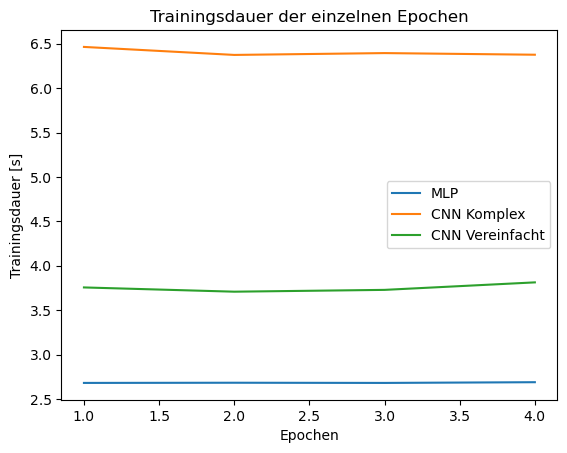

In [26]:
fig, ax = plt.subplots()
ax.plot(range(1, len(history_mlp['train_duration']) + 1), history_mlp['train_duration'], label="MLP")
ax.plot(range(1, len(history_cnn['train_duration']) + 1), history_cnn['train_duration'], label="CNN Komplex")
ax.plot(range(1, len(history_cnn_simple['train_duration']) + 1), history_cnn_simple['train_duration'], label="CNN Vereinfacht")
ax.set_ylabel("Trainingsdauer [s]")
ax.set_xlabel("Epochen")
plt.title("Trainingsdauer der einzelnen Epochen")
plt.legend()
plt.show()

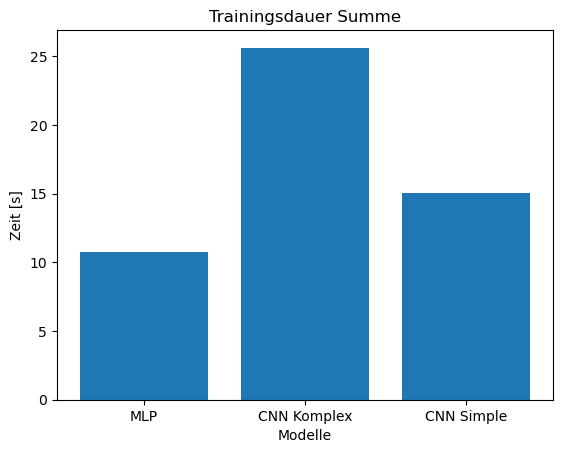

In [27]:
data = [
    np.sum(history_mlp['train_duration']),
    np.sum(history_cnn['train_duration']),
    np.sum(history_cnn_simple['train_duration']),
]

labels = [
    "MLP",
    "CNN Komplex",
    "CNN Simple",
]

fig, ax = plt.subplots()
ax.bar(x=labels, height=data)
ax.set_ylabel("Zeit [s]")
ax.set_xlabel("Modelle")
plt.title("Trainingsdauer Summe")
plt.show()

### Trainingsergebnisse vergleichen

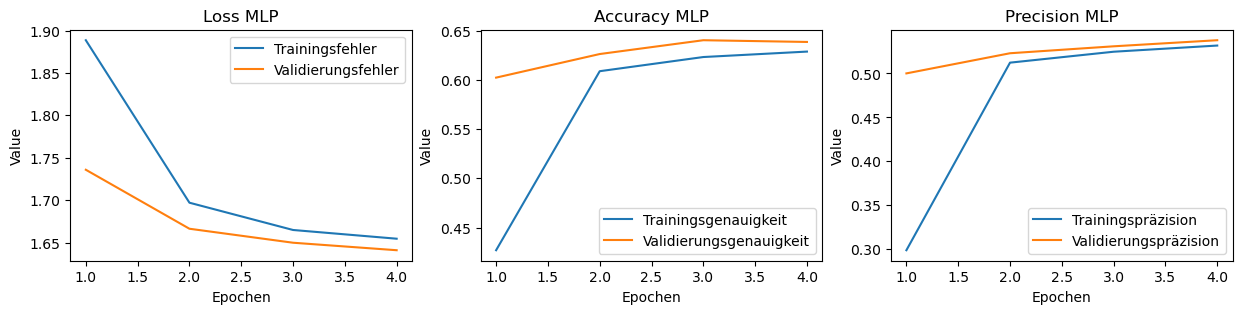

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
ax[0].plot(range(1, len(history_mlp['loss']['train']) + 1), history_mlp['loss']['train'], label='Trainingsfehler')
ax[0].plot(range(1, len(history_mlp['loss']['val']) + 1), history_mlp['loss']['val'], label='Validierungsfehler')
ax[1].plot(range(1, len(history_mlp['acc']['train']) + 1), history_mlp['acc']['train'], label='Trainingsgenauigkeit')
ax[1].plot(range(1, len(history_mlp['acc']['val']) + 1), history_mlp['acc']['val'], label='Validierungsgenauigkeit')
ax[2].plot(range(1, len(history_mlp['precision']['train']) + 1), history_mlp['precision']['train'], label='Trainingspräzision')
ax[2].plot(range(1, len(history_mlp['precision']['val']) + 1), history_mlp['precision']['val'], label='Validierungspräzision')

ax[0].set_ylabel("Value")
ax[0].set_xlabel("Epochen")
ax[1].set_ylabel("Value")
ax[1].set_xlabel("Epochen")
ax[2].set_ylabel("Value")
ax[2].set_xlabel("Epochen")

ax[0].title.set_text("Loss MLP")
ax[1].title.set_text("Accuracy MLP")
ax[2].title.set_text("Precision MLP")

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.show()

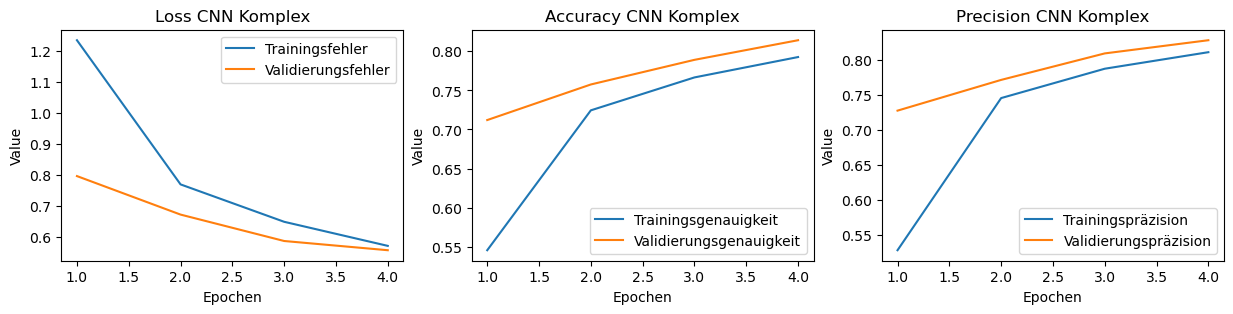

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
ax[0].plot(range(1, len(history_cnn['loss']['train']) + 1), history_cnn['loss']['train'], label='Trainingsfehler')
ax[0].plot(range(1, len(history_cnn['loss']['val']) + 1), history_cnn['loss']['val'], label='Validierungsfehler')
ax[1].plot(range(1, len(history_cnn['acc']['train']) + 1), history_cnn['acc']['train'], label='Trainingsgenauigkeit')
ax[1].plot(range(1, len(history_cnn['acc']['val']) + 1), history_cnn['acc']['val'], label='Validierungsgenauigkeit')
ax[2].plot(range(1, len(history_cnn['precision']['train']) + 1), history_cnn['precision']['train'], label='Trainingspräzision')
ax[2].plot(range(1, len(history_cnn['precision']['val']) + 1), history_cnn['precision']['val'], label='Validierungspräzision')

ax[0].set_ylabel("Value")
ax[0].set_xlabel("Epochen")
ax[1].set_ylabel("Value")
ax[1].set_xlabel("Epochen")
ax[2].set_ylabel("Value")
ax[2].set_xlabel("Epochen")

ax[0].title.set_text("Loss CNN Komplex")
ax[1].title.set_text("Accuracy CNN Komplex")
ax[2].title.set_text("Precision CNN Komplex")

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.show()

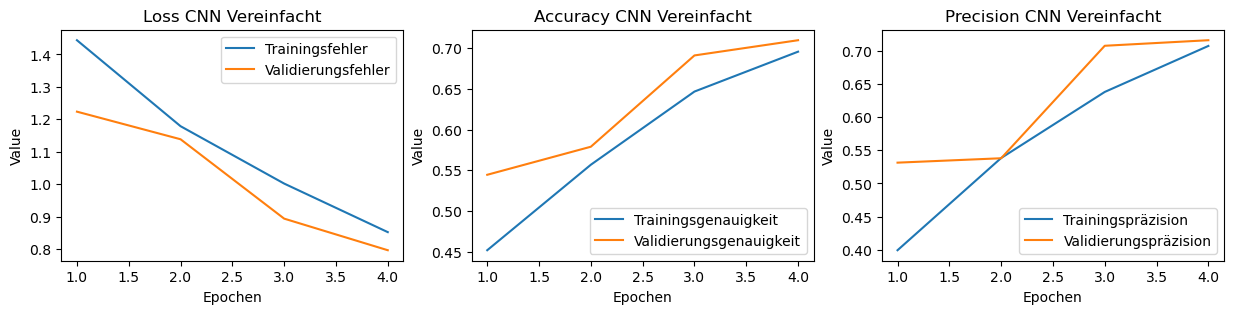

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
ax[0].plot(range(1, len(history_cnn_simple['loss']['train']) + 1), history_cnn_simple['loss']['train'], label='Trainingsfehler')
ax[0].plot(range(1, len(history_cnn_simple['loss']['val']) + 1), history_cnn_simple['loss']['val'], label='Validierungsfehler')
ax[1].plot(range(1, len(history_cnn_simple['acc']['train']) + 1), history_cnn_simple['acc']['train'], label='Trainingsgenauigkeit')
ax[1].plot(range(1, len(history_cnn_simple['acc']['val']) + 1), history_cnn_simple['acc']['val'], label='Validierungsgenauigkeit')
ax[2].plot(range(1, len(history_cnn_simple['precision']['train']) + 1), history_cnn_simple['precision']['train'], label='Trainingspräzision')
ax[2].plot(range(1, len(history_cnn_simple['precision']['val']) + 1), history_cnn_simple['precision']['val'], label='Validierungspräzision')

ax[0].set_ylabel("Value")
ax[0].set_xlabel("Epochen")
ax[1].set_ylabel("Value")
ax[1].set_xlabel("Epochen")
ax[2].set_ylabel("Value")
ax[2].set_xlabel("Epochen")

ax[0].title.set_text("Loss CNN Vereinfacht")
ax[1].title.set_text("Accuracy CNN Vereinfacht")
ax[2].title.set_text("Precision CNN Vereinfacht")

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.show()

### Confusion Matrix MLP

In [31]:
cm_model = model_mlp
# cm_model = model_cnn
# cm_model = model_cnn_simple

y_test = []
y_pred = []

# Abschalten der Gradientenberechnung (nicht notwendig bei Evaluation)
with torch.no_grad():
    # Umschalten vom Training- in den Evaluationsmodus
    cm_model.eval()

    for X, y in tl:
        output = cm_model(X)
        _, pred_label = torch.max(output, dim=1)
        y_test += y.numpy().tolist()
        y_pred += pred_label.numpy().tolist()

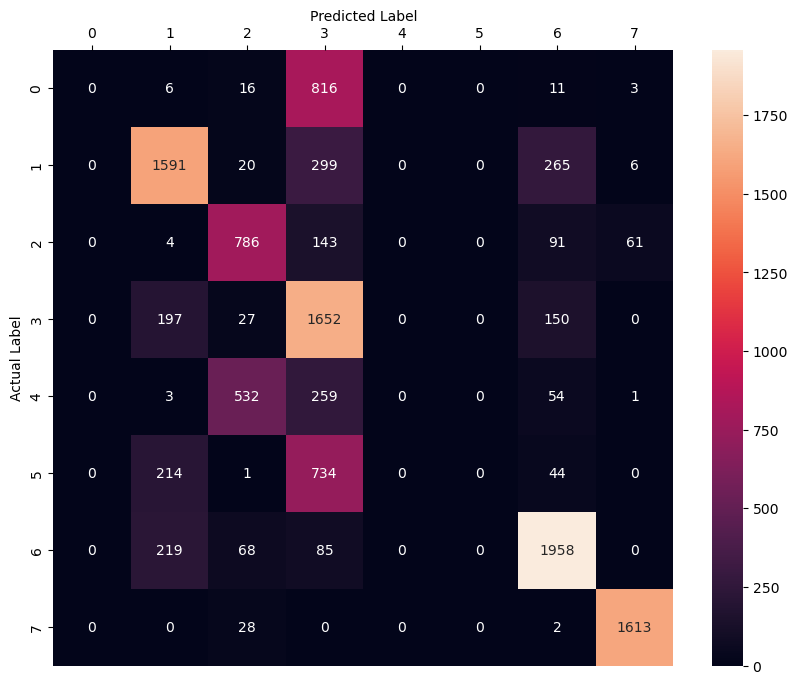

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.subplots(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")
plt.show()

### Confusion Matrix CNN Komplex

In [33]:
cm_model = model_cnn

y_test = []
y_pred = []

# Abschalten der Gradientenberechnung (nicht notwendig bei Evaluation)
with torch.no_grad():
    # Umschalten vom Training- in den Evaluationsmodus
    cm_model.eval()

    for X, y in tl:
        output = cm_model(X)
        _, pred_label = torch.max(output, dim=1)
        y_test += y.numpy().tolist()
        y_pred += pred_label.numpy().tolist()

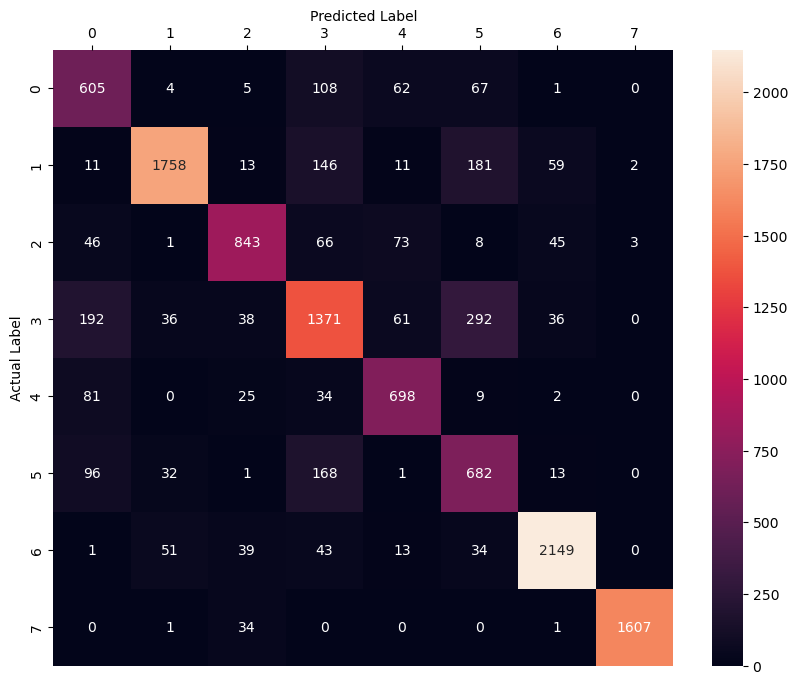

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.subplots(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")
plt.show()

### Confusion Matrix CNN Vereinfacht

In [35]:
cm_model = model_cnn_simple

y_test = []
y_pred = []

# Abschalten der Gradientenberechnung (nicht notwendig bei Evaluation)
with torch.no_grad():
    # Umschalten vom Training- in den Evaluationsmodus
    cm_model.eval()

    for X, y in tl:
        output = cm_model(X)
        _, pred_label = torch.max(output, dim=1)
        y_test += y.numpy().tolist()
        y_pred += pred_label.numpy().tolist()

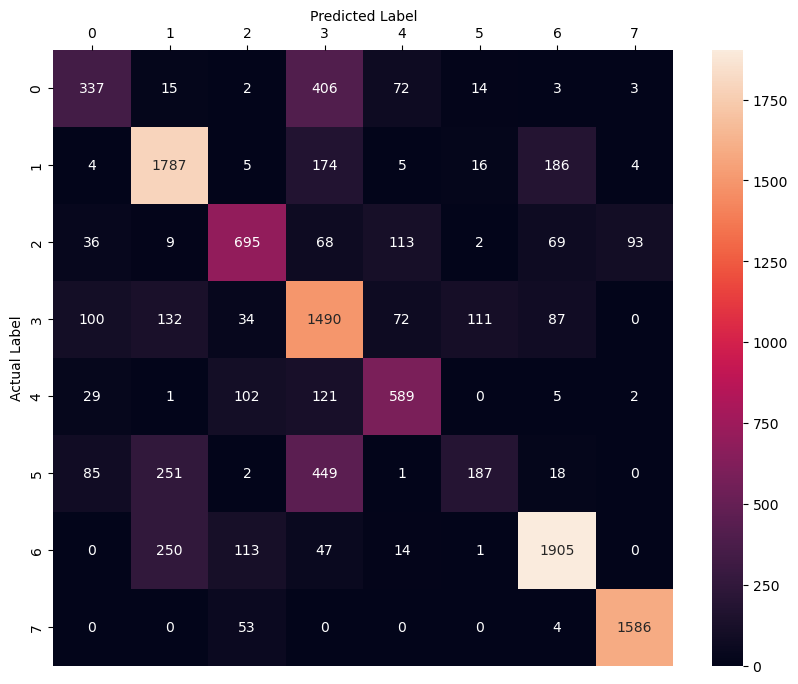

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.subplots(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")
plt.show()

### Aufgabe 1: 

Vergleichen Sie die Trainingszeiten der jeweiligen Modelle mit $4, 16,$ und $32$ Epochen.

**Anpassung in:** Abschnitt *Trainingsparameter*

* Welche Größe eines Modells ist vor allem relevant für die Dauer des Trainings?
* Manchmal beobachtet man Schwankungen in der Trainingszeit, z.B. auch bei der Abfolge von verschiedenen Epochen. Sind diese modellbedingt? Oder lassen sie sich ggf. auch anders erklären?

**Hinweis:** Führen Sie vor jeden Durchlauf ein *Restart* des Kernels durch!


### Aufgabe 2:

a) Wechseln Sie die Evaluationsfunktion zu einer häufig verwendeten, aber problematischen (naiven) Berechnung von Metriken und vergleichen Sie die Genauigkeit (Accuracy) der Trainingsergebnisse mit den Ergebnissen mit der Multi-Class Evaluation.

Diskutieren Sie anhand einer Betrachtung der confusion matrix, welche Aspekte eine solche Berechnung der accuracy nicht darstellen kann. 

**Hinweis:** Sie können die Plots der Ergebnisse als Bild abspeichern. Dies erleichtert die Vergleiche.

**Anpassung in:** Abschnitt *Zu verwendende Evaluationsfunktion festlegen*

b) Wechseln Sie die Evaluationsfunktion zurück zur Multi-Class Evaluation. Trainineren Sie dann alle Modelle mit jeweils $100$ Epochen. Vergleichen Sie dann die Trainingsergebnisse der verschiedenen Modelle:

* Wie gut funktionieren die Modelle und wie lässt sich das Anhand der Metriken feststellen?
* Welche Aussagen über die Funktionalität der Modelle lassen sich anhand der Konfusionsmatrizen treffen?

c) Untersuchen Sie, ob ausreichend Daten für das Training eingesetzt wurden. Ein erster Anhaltspunkt dazu kann eine grobe Abschätzung der Konvergenz der Vorhersagen des Modells mit Blick auf die verwendeten Datensätze geben.  Vergleichen Sie dazu die Modellperformance bei einem Training mit einem künstlich reduzierten Datensatz. Trainieren Sie dazu jeweils mit Anteilen der Daten (50%, 75%, 100%)

* Wie wirken sich die unterschiedlichen Datensätze auf die Trainingsergebnisse aus?

### Aufgabe 3: 

Modifizieren Sie das komplexe Beispiel für ein CNN so, dass anstatt der 2 MaxPoolings in den beiden Blöcken nur einmal eine Routine Maxpooling verwendet wird. Hierzu müssen die Parameter des verbleibenden MaxPoolings mit geeigneten Größen modifiziert werden.

**Anpassung in:** Abschnitt *Definiere: Komplexes CNN*

* Sind Unterschiede in den Trainingsergebnissen erkennbar?